The `Circuit` class provided by PyQC provides several alternative means of defining quantum circuits which can be simulated (on a small number of qubits) without building up algebraic expressions of operators.  Circuits are a straightforward way to program quantum algorithms, and as instances of the `Circuit` class are also `Gate` objects, they can be used to create new gates for use as subroutines in more complex circuits.  Another feature of `Circuit` objects is that they can be rendered as circuit diagrams.

The `Circuit` class can also be used to read in circuits from quantum assembly languages.  Currently only two languages are supported:  The pseudo-assembly language used by [qasm2circ](http://www.media.mit.edu/quanta/qasm2circ/) by Isaac Chuang, as it is also (currently) used to generate PyQC's circuit diagrams.  Within certain limitations this turns out to be an okay language for providing instructions to a circuit.  The other is the simple language used by Scott Aaronson's `chp` program, as part of the experimental support for stabilizer circuits.  There is also support for an extended version of this language that includes instructions for the Pauli operators.  At least partial support for QCL and Quipper's programming language are also planned once a bit more of the necessary machinery is in place.

As explained in the introduction to this documentation, the primary format for creating a circuit is a list of instructions, where each instruction is a tuple consisting of an operator and one or more arguments.  Here we can use the gate objects themselves, `H`, `CNOT`, `X`, and so on, as glyphs representing that gate in the instruction list.  For single-qubit gates, the argument is simply an integer specifying which qubit to apply the operator to (numbered from 0 to n - 1).  For multi-qubit gates, including control gates, the arguments are given as a tuple of arguments).

A circuit, for example, consisting of a single Hadamard gate is defined like this:

In [1]:
from pyqc import *

Circuit([(H, 0)])

Naturally, this is exactly equivalent to just using the H gate directly:

In [2]:
H == Circuit([(H, 0)])

True

`Circuit` instances are themselves gates, and share all the same semantics as the `Gate` and `Operator` classes.  For example, we can provide input to a circuit by acting on a `Ket` object with it:

In [3]:
Circuit([(X, 0)])|Ket(0)

|1>

Same applies for circuits of more than one qubit:

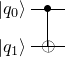

In [4]:
Circuit([(CNOT, (0, 1))])

In [5]:
Circuit([(CNOT, (0, 1))])|Ket(1, 0)

|1, 1>

Here is a more complete example, implementing a full circuit for a 3-qubit QFT.  To implement this circuit we first also defined a controlled phase gate and a controlled T-gate:

In [6]:
C_S = ControlledGate(S)
C_T = ControlledGate(T)

QFT_3 = Circuit([
    (H, 0),
    (C_S, (1, 0)),
    (C_T, (2, 0)),
    (H, 1),
    (C_S, (2, 1)),
    (H, 2),
    (SWAP, (0, 2))
])

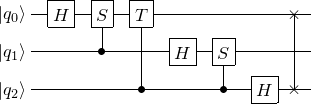

In [7]:
QFT_3

In [8]:
QFT_3|Ket(0, 0, 0)

sqrt(1/8)(|0, 0, 0> + |0, 0, 1> + |0, 1, 0> + |0, 1, 1> + |1, 0, 0> + |1, 0, 1> + |1, 1, 0> + |1, 1, 1>)

## To/From QASM

This circuit can also be dumped to the [qasm2circ](http://www.media.mit.edu/quanta/qasm2circ/) format as a string:

In [9]:
print(QFT_3.to_qasm())

	def	c-S,1,'S'
	def	c-T,1,'T'

	qubit	q0
	qubit	q1
	qubit	q2

	H	q0
	c-S	q1,q0
	c-T	q2,q0
	nop	q1
	H	q1
	c-S	q2,q1
	H	q2
	swap	q0,q2


These QASM scripts can also be read in to pyqc using the `Circuit.from_string` classmethod.  This does not yet work perfectly for all cases, but for many common cases it does.  In particular, QASM output by `Circuit.to_qasm` will always round-trip:

In [10]:
QFT_3_from_qasm = Circuit.from_qasm(QFT_3.to_qasm())

The resultant object is a fully capable PyQC `Circuit`.  Its circuit diagram can be displayed, and it can be evaluated on input states:

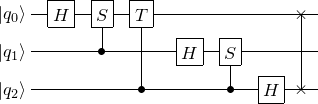

In [11]:
QFT_3_from_qasm

In [12]:
QFT_3_from_qasm|Ket(0, 0, 0)

sqrt(1/8)(|0, 0, 0> + |0, 0, 1> + |0, 1, 0> + |0, 1, 1> + |1, 0, 0> + |1, 0, 1> + |1, 1, 0> + |1, 1, 1>)

However, for an arbitrary QASM input, the resultant `Circuit` object will not always be executable.  Take for example the following sample QASM script, with two inputs, that places the inputs in a superposition and then applies a two-qubit gate named "U":

In [13]:
sample_qasm = """
 defbox    U_0,2,0,'U_0'
 
 qubit     q0
 qubit     q1
 
 H         q0
 H         q1
 U_0       q0,q1
 H         q0
 H         q1
"""

C = Circuit.from_qasm(sample_qasm)

/home/embray/src/pyqc/pyqc/circuit.py:294: UserWarning: Input QASM defines the following gates unrecognized by pyqc:

    U_0

Until operations are defined for these gates the circuit cannot be evaluated.  You can register these gates using the register=True argument when creating a new gate object.  For example:

    >>> G = Gate(<..matrix elements..>, name=U_0,
    ...          register=True)

The diagram for this circuit can still be displayed, but the circuit cannot be evaluated until the unknown gates are registered with pyqc.
  f"Input QASM defines the following gates unrecognized by "


As the warning indicates, the `Circuit` instantiation is not quite sure what to do with the custom gate `U_0` defined in this QASM script.  There are no gates of that name known to PyQC.  We can still display this circuit diagram just as though in the input were passed to qasm2circ:

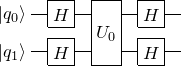

In [14]:
C

But any attempt to evaluate the circuit will fail with the previous admonition:

In [15]:
try:
    C|Ket(0, 0)
except Exception as e:
    print(e)

The gate 'U_0' is currently a placeholder for an undefined gate.  In order for this circuit to be evaluated a `Gate` instance with the name 'U_0' must be created and registered in the global gate registry.  For example:

    >>> custom_gate = Gate([[...]], name='U_0', register=True)


In order to make this `Circuit` useful we need to define a new `Gate` with the name `'U_0'` and add it to a *registry* of known gates.  This is done by passing the `register=True` argument to the `Gate` constructor--currently, gates are not automatically added to the registry (though all the gates built in to PyQC are registered).  For example, we could define:

In [16]:
U_0 = Gate(Z * Z, name='U_0', register=True)

The act of registering this gate with the name `'U_0'` immediately makes the previously defined circuit usable:

In [17]:
C|Ket(0, 0)

|1, 1>

(Incidentally, the resultant circuit is equivalent to an $ X $ gate on both qubits:)

In [18]:
C == Circuit([(X, 0), (X, 1)])

True

Note that now that `'U_0'` is registered we are prevented from accidentally re-registering it and possibly overriding the previous definition:

In [19]:
try:
    U_0 = Gate(Y * Y, name='U_0', register=True)
except Exception as e:
    print(e)

An Operator with the name 'U_0' has already been defined. Use the replace=True argument to override the existing Operator.  The existing Operator will continue to work in existing circuits but may not be usable in new ones.


That is, unless we force it with the `replace=True` argument:

In [20]:
U_0 = Gate(Y * Y, name='U_0', register=True, replace=True)

/home/iguananaut/src/pyqc/pyqc/operator.py:113: UserWarning: Replacing existing Operator 'U_0'.
  "Replacing existing Operator {0!r}.".format(name))


Note that this does *not* change the functionality of the previous circuit that used the `U_0` gate.  It still has a reference to the old gate.  This prevents the circuit's functionality from changing in place.  Still, this is useful, as the same circuit can be used like a template for new circuits, just by swapping out the `U_0` gate.  If we create a new `Circuit` from the same QASM script it will use the new definition of `U_0`:

In [21]:
C2 = Circuit.from_qasm(sample_qasm)

In [22]:
C2|Ket(0, 0)

-|1, 1>

## From Wire Lists

This alternative method for instantiating a `Circuit` was actually the original format designed for PyQC.  The idea was to be able to write out a circuit in valid Python syntax that follows a similar visual flow to that of a circuit *diagram*.

In practice, this format turned out be cumbersome for anything but toy cases, but it is still included (and documented) for completeness.

The idea is to provide a list of lists, where each list represents a single *wire* in a quantum circuit--that is, the list of instructions performed on each qubit.  These lists can be passed in to the `Circuit.from_wires` method to create a new `Circuit`.  For example, for a single wire:

In [23]:
Circuit.from_wires([H, Z, H])

Multi-qubit gates are more complicated in that they span multiple wires.  To support this, multi-qubit `Gate` bojects have labels representing each of their inputs.  For example `CNOT.target` and `CNOT.control` (or we can use `CNOT.t` and `CNOT.c` for short).  The `.target` and `.control` labels are also provided by default on custom `ControlledGate` objects.  Single qubit gates also have a label for their single input as well, but this is not generally useful.  For example we can implement the 3-qubit QFT from before as follows:

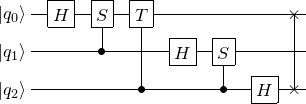

In [24]:
CS = ControlledGate(S)
CT = ControlledGate(T)

Circuit.from_wires(
    [H, CS.t, CT.t, I, I,    I, SWAP.q0],
    [I, CS.c, I   , H, CS.t, I, I      ],
    [I, I,    CT.c, I, CS.c, H, SWAP.q1]
)

The resultant `Circuit` object is otherwise equivalent in every way to circuits defined from other formats.

Note how this required manually inserting all the "blanks" on the wire as `I`.  This is just one of the problems that wound up making this format more difficult to work with than it was hoped.  Any ideas for improving it are, however, welcome.